In [2]:
import pynwb

import numpy as np

from pynwb import NWBHDF5IO, NWBFile, TimeSeries

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from sklearn.cluster import KMeans
import bisect

import autograd.numpy as np
import autograd.numpy.random as npr

from data_loaders import *

/Users/liuweixuan/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/liuweixuan/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ARHMM Initialization restarts:   0%|                      | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -122759.1: 100%|██████████████████████████| 20/20 [04:22<00:00, 13.14s/it]


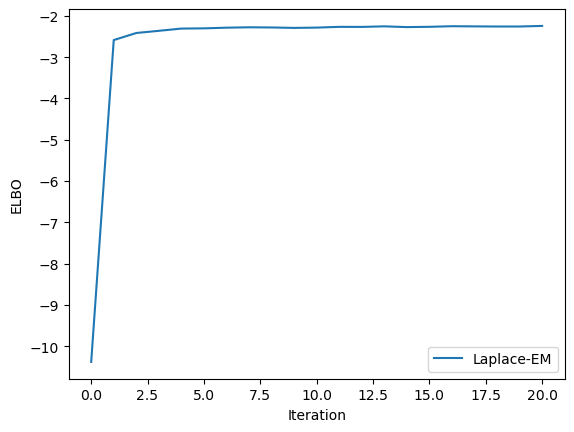

In [3]:
# Original data, LDS fitting and the elbos plot
import ssm
from ssm.util import random_rotation

filename = "sub-monk-g_ses-session0.nwb"
filename = "sub-monk-j_ses-session0.nwb"
# filename = "sub-monk-j_ses-session1.nwb"

num_permutation = 5
original_input, original_spike, p_input_matrices, p_spike_matrices = getData_for_LDS(filename, 
                                                                                   num_permutation = num_permutation)

obs=original_spike
inputs = original_input

# Known paramters
time_bins = obs.shape[0]
obs_dim = obs.shape[1]
input_dim = 4

# Assumption
state_dim = 4

# fit the model
# Poisson emission
lds_inp = ssm.LDS(obs_dim, state_dim, M=input_dim, emissions="poisson")
elbos, q = lds_inp.fit((obs).astype(int), inputs=inputs, num_iters=20)

# Plot the ELBOs
plt.plot(elbos/time_bins, label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()
plt.show()

In [4]:
# eigenvalues and eigenvectors
A = lds_inp.dynamics.A
eigenvalues, eigenvectors = np.linalg.eig(A)
print(eigenvalues)

[-0.25502034+0.41558672j -0.25502034-0.41558672j -0.00493911+0.j
 -0.01318932+0.j        ]


ARHMM Initialization restarts:   0%|                      | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -122735.4: 100%|██████████████████████████| 20/20 [04:02<00:00, 12.14s/it]


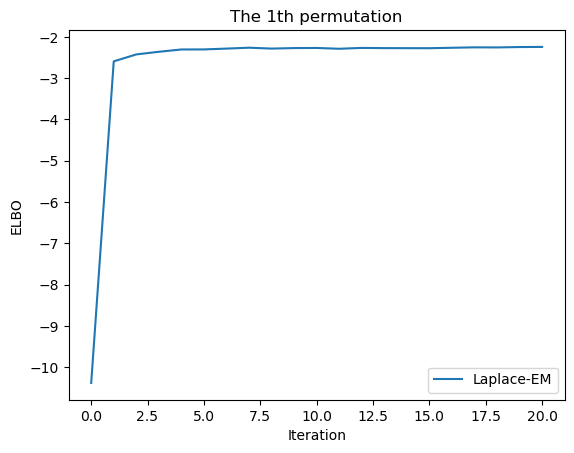

ARHMM Initialization restarts:   0%|                      | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -122976.4: 100%|██████████████████████████| 20/20 [07:27<00:00, 22.40s/it]


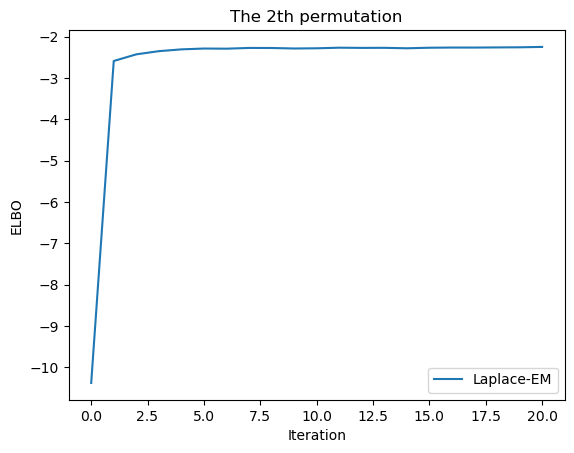

ARHMM Initialization restarts:   0%|                      | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -122682.1: 100%|██████████████████████████| 20/20 [03:41<00:00, 11.07s/it]


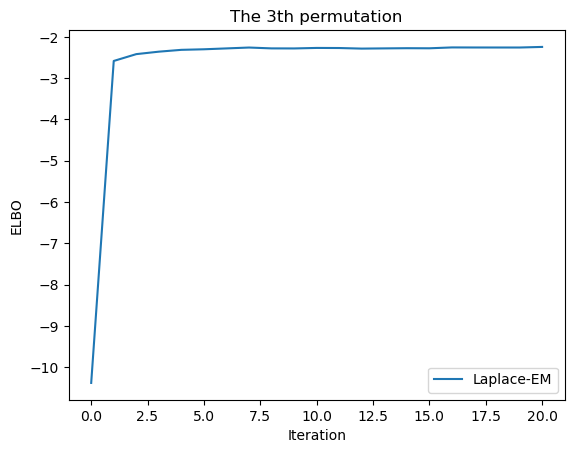

ARHMM Initialization restarts:   0%|                      | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -122532.9: 100%|██████████████████████████| 20/20 [03:29<00:00, 10.46s/it]


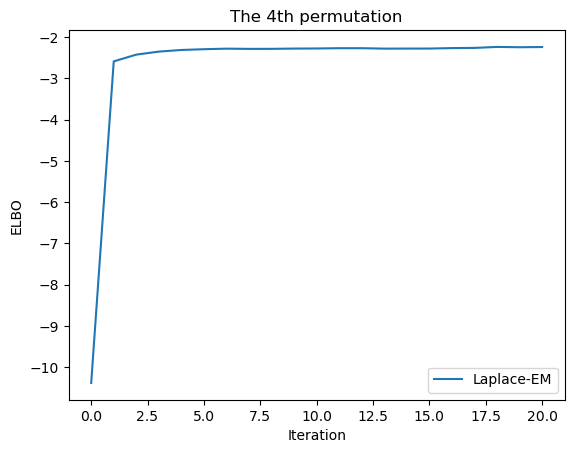

ARHMM Initialization restarts:   0%|                      | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -122336.4: 100%|██████████████████████████| 20/20 [03:28<00:00, 10.41s/it]


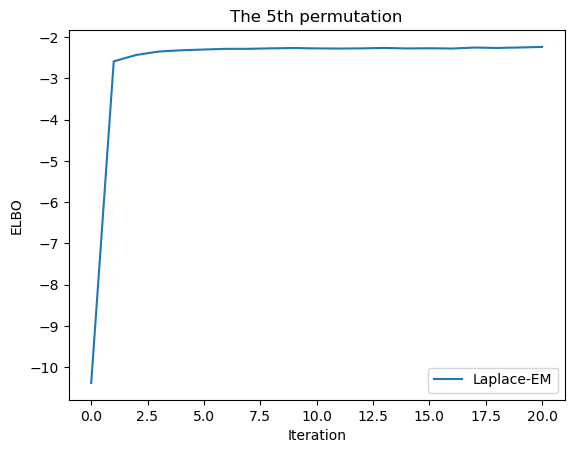

[array([[-0.61452211, -0.13278577, -0.38521028,  0.30711704],
        [ 0.84031023, -0.00177633,  0.43830271, -0.35325305],
        [ 0.30584981, -0.03619103,  0.12386272, -0.11310401],
        [-0.04818422,  0.05476203,  0.00530612, -0.00513325]]),
 array([[-0.60190764, -0.16367761,  0.23991753, -0.14789242],
        [-0.17271214, -0.05328396,  0.07370605, -0.0448091 ],
        [-0.67925798, -0.18578929,  0.09164951, -0.03138179],
        [ 0.77625252,  0.21418427, -0.16455517,  0.06063681]]),
 array([[-0.33874016, -0.15679727, -0.48701309,  0.08876767],
        [ 0.60473418,  0.1125598 ,  0.79331259, -0.22177731],
        [-0.05684831, -0.12839529, -0.1588838 , -0.02516026],
        [ 0.34543237,  0.10274237,  0.46791678, -0.11881845]]),
 array([[ 0.12568498,  0.23281418,  0.22126736, -1.0852073 ],
        [-0.12840793, -0.1045713 , -0.08561096,  0.49843063],
        [-0.09737273, -0.08149568, -0.07939536,  0.4259621 ],
        [ 0.21710536,  0.057975  ,  0.05108698, -0.4536232 ]]),


In [5]:
# Permutated data, LDS fitting and elbos plots
As=[]
for p_id in range(len(p_input_matrices)):
    p_input = p_input_matrices[p_id]
    p_spike = p_spike_matrices[p_id]
    
    # Poisson emission
    lds_inp = ssm.LDS(obs_dim, state_dim, M=input_dim, emissions="poisson")
    elbos, q = lds_inp.fit((p_spike).astype(int), inputs=p_input, num_iters=20)
    As.append(lds_inp.dynamics.A)
    # Plot the ELBOs
    plt.figure()
    plt.plot(elbos/time_bins, label="Laplace-EM")
    plt.xlabel("Iteration")
    plt.ylabel("ELBO")
    plt.title(f"The {p_id + 1}th permutation")
    plt.legend()
    plt.show()
As

In [6]:
#eignevalues and eigenvectors
for A in As:
    eigenvalues, eigenvectors = np.linalg.eig(A)
    print(f'values: \n{eigenvalues}')
    #\n vectors\in{eigenvectors}.')

values: 
[-0.24033425+0.37596627j -0.24033425-0.37596627j -0.00402544+0.j
 -0.01287504+0.j        ]
values: 
[-0.24246761+0.37135416j -0.24246761-0.37135416j -0.00566053+0.j
 -0.01230954+0.j        ]
values: 
[-0.24367864+0.38595442j -0.24367864-0.38595442j -0.01193842+0.j
 -0.00458691+0.j        ]
values: 
[-0.24774229+0.41408597j -0.24774229-0.41408597j -0.01244522+0.j
 -0.00397507+0.j        ]
values: 
[-0.24957095+0.41104551j -0.24957095-0.41104551j -0.01324856+0.j
 -0.00382567+0.j        ]


ARHMM Initialization restarts:   0%|                      | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -134820.3: 100%|██████████████████████████| 20/20 [02:23<00:00,  7.17s/it]


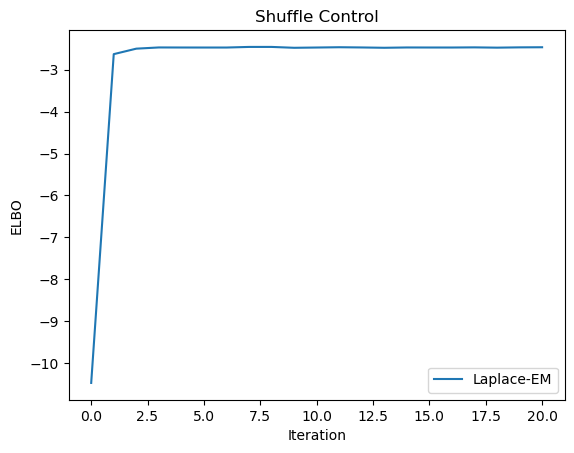

In [7]:
# Shuffle control

num_timepoints, num_neurons = original_spike.shape
shift_amounts = np.random.randint(0, num_timepoints, size=num_neurons)

# Apply circular shift independently for each neuron
shuffled_activity = np.zeros_like(original_spike)

for neuron in range(num_neurons):
    shuffled_activity[:, neuron] = np.roll(original_spike[:, neuron], shift_amounts[neuron])
    
# fit the model
# Poisson emission
lds_inp = ssm.LDS(obs_dim, state_dim, M=input_dim, emissions="poisson")
elbos, q = lds_inp.fit((shuffled_activity).astype(int), inputs=original_input, num_iters=20)

# Plot the ELBOs
plt.plot(elbos/num_timepoints, label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("Shuffle Control")
plt.legend()
plt.show()

In [9]:
# eigenvalues and eigenvectors
A = lds_inp.dynamics.A
eigenvalues, eigenvectors = np.linalg.eig(A)
print(eigenvalues)
# print(eigenvectors)

[-0.03320715+0.j         -0.08355392+0.j         -0.10388993+0.00356521j
 -0.10388993-0.00356521j]
